# ZFNet PyTorch with CIFAR10
- **Task**: Classification
- **Data**: CIFAR10 Dataset
- **Model**: ZFNet
- **Loss function**: Cross Entropy Loss
- **Optimization**: Adam

In [1]:
!pip install -q watermark

In [2]:
%load_ext watermark
%watermark -a 'Nguyen Van Sy Thinh' -v -p torch

Author: Nguyen Van Sy Thinh

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.20.0

torch: 2.1.2



## 1. Import Library

In [3]:
!pip install -q torchsummary

In [4]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import time

import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchsummary import summary

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

## 2. Data

### 2.1. CIFAR10 Dataset

#### 2.1.1. Load dataset to compute Mean and Std to Normalize Z-score

In [5]:
# Load dataset with only the ToTensor transform to compute mean and std
compute_transform = transforms.Compose([transforms.ToTensor()])
dataset = CIFAR10(root='data', train=True, transform=compute_transform, download=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False, num_workers=2)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

variance = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    variance += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(variance / (len(loader.dataset)*28*28))

print(mean, std)

100%|██████████| 170498071/170498071 [00:10<00:00, 16084200.34it/s]


Extracting data/cifar-10-python.tar.gz to data
tensor([0.4914, 0.4822, 0.4465]) tensor([0.2823, 0.2783, 0.2990])


#### 2.1.2. Load CIFAR10 Dataset

In [6]:
batch_size = 64
# Load CIFAR10 dataset
transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2823, 0.2783, 0.2990))])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### 2.2. Data Information

In [7]:
print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")

Number of training samples: 50000
Number of testing samples: 10000


In [8]:
print(f"Datatype of the 1st training sample: {trainset[0][0].type()}")
print(f"Size of the 1st training sample: {testset[0][0].size()}")

Datatype of the 1st training sample: torch.FloatTensor
Size of the 1st training sample: torch.Size([3, 224, 224])


### 2.3. Data Visualization

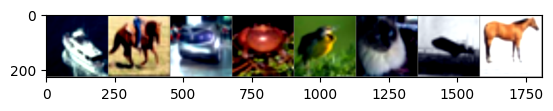

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

## 3. Model

In [10]:
class ZFNet(nn.Module):
    """ A implementation of the ZFNet architecture from the paper 'Visualizing and
        Understanding Convolutional Networks' by Zeiler and Fergus"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3, padding_mode='reflect')
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=2, padding_mode='reflect')
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.fc6 = nn.Linear(9216,4096)
        self.fc7 = nn.Linear(4096,4096)
        self.fc8 = nn.Linear(4096,num_classes)
        self.pool1 = nn.MaxPool2d(3,stride=2)
        self.pool2 = nn.MaxPool2d(3,stride=2)
        self.drop = nn.Dropout(0.5)
        self.drop = nn.Dropout(0.5)
        self.lrn = nn.LocalResponseNorm(size=5,alpha=10e-4,beta=0.75,k=2.0)

    def forward(self, x):
        x = self.lrn(self.pool1(F.relu(self.conv1(x))))
        x = self.lrn(self.pool2(F.relu(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(F.relu(self.conv5(x)))
        x = x.view(-1,9216)
        x = F.relu(self.drop(self.fc6(x)))
        x = F.relu(self.drop(self.fc7(x)))
        x = self.fc8(x)
        return x

In [11]:
model = ZFNet(num_classes=10).to(device)

In [12]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 112, 112]          14,208
         MaxPool2d-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
            Conv2d-4          [-1, 256, 28, 28]         614,656
         MaxPool2d-5          [-1, 256, 13, 13]               0
 LocalResponseNorm-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
            Conv2d-8          [-1, 384, 13, 13]       1,327,488
            Conv2d-9          [-1, 256, 13, 13]         884,992
        MaxPool2d-10            [-1, 256, 6, 6]               0
           Linear-11                 [-1, 4096]      37,752,832
          Dropout-12                 [-1, 4096]               0
           Linear-13                 [-1, 4096]      16,781,312
          Dropout-14                 [-

In [13]:
# Generating a random tensor
input_tensor = torch.rand(1, 3, 224, 224).to(device)

# Feeding the tensor into the model
output = model(input_tensor)
print(output.shape)

torch.Size([1, 10])


## 4. Loss Function and Optimization

In [14]:
LR = 1e-3
EPOCHS = 150

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

## 5. Train

### 5.1. Evaluation Function

In [16]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [17]:
test_loss, test_accuracy = evaluate(model, testloader, criterion)
print(f'Test_loss: {test_loss}')
print(f'Test_accuracy: {test_accuracy}')

Test_loss: 2.302672904008513
Test_accuracy: 10.0


In [18]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [19]:
# train
for epoch in range(EPOCHS):
    start_time = time.time()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Time: {time.time() - start_time:.3f}s")

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/150], Loss: 1.6763, Accuracy: 37.63%, Test Loss: 1.4196, Test Accuracy: 46.86%, Time: 103.001s
Epoch [2/150], Loss: 1.3226, Accuracy: 52.23%, Test Loss: 1.2874, Test Accuracy: 54.67%, Time: 103.216s
Epoch [3/150], Loss: 1.1342, Accuracy: 59.84%, Test Loss: 1.1468, Test Accuracy: 59.67%, Time: 103.238s
Epoch [4/150], Loss: 0.9735, Accuracy: 65.42%, Test Loss: 1.0410, Test Accuracy: 63.52%, Time: 103.456s
Epoch [5/150], Loss: 0.8243, Accuracy: 70.90%, Test Loss: 1.0401, Test Accuracy: 64.87%, Time: 103.441s
Epoch [6/150], Loss: 0.6880, Accuracy: 75.57%, Test Loss: 1.0759, Test Accuracy: 64.76%, Time: 103.592s
Epoch [7/150], Loss: 0.5466, Accuracy: 80.25%, Test Loss: 1.1452, Test Accuracy: 66.47%, Time: 102.961s
Epoch [8/150], Loss: 0.4176, Accuracy: 85.05%, Test Loss: 1.2415, Test Accuracy: 65.43%, Time: 103.014s
Epoch [9/150], Loss: 0.3041, Accuracy: 89.32%, Test Loss: 1.5543, Test Accuracy: 64.55%, Time: 103.152s
Epoch [10/150], Loss: 0.2449, Accuracy: 91.47%, Test Loss: 1.702

## 6. Inference

### 6.1. Loss Visualization

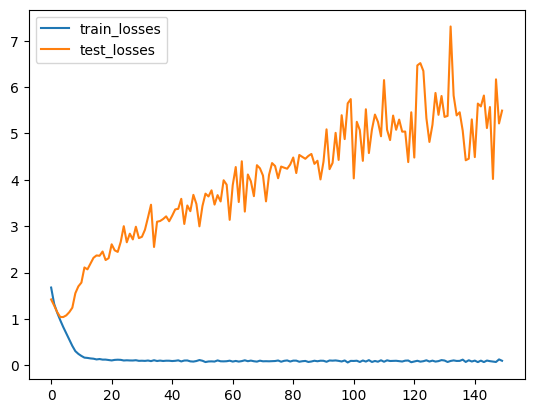

In [20]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

### 6.2. Accuracy Visualization

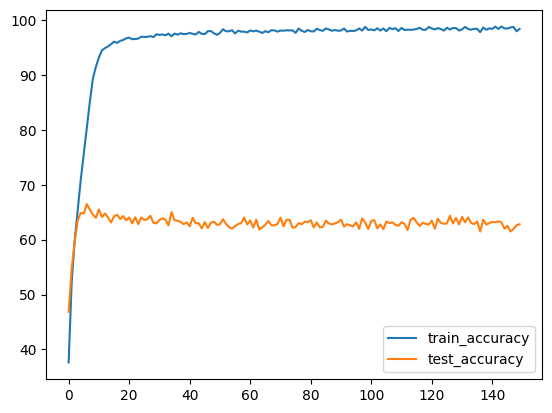

In [21]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

### 6.3. Best Accuracy

In [22]:
# the best accuracy
best_epoch_test = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch_test + 1} with test accuracy: {test_accuracies[best_epoch_test]:.2f}%")
best_epoch_train = np.argmax(train_accuracies)
print(f"\nBest epoch: {best_epoch_train + 1} with train accuracy: {train_accuracies[best_epoch_train]:.2f}%")


Best epoch: 7 with test accuracy: 66.47%

Best epoch: 144 with train accuracy: 98.81%


## 7. Conclusion
- **Accuracy**: 90.91%